# Matrix Factorization

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../')

from pathlib import Path

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn import MSELoss

from src.models.torch.losses import L1Loss, L2Loss
from src.models.torch.mf import MatrixFactorization
from src.models.torch.trainer import Trainer
from src.util.data import get_interactions, get_sparsity_factor, get_train_test_ratings
from src.util.metrics import get_jaccard_ranking, get_classification_ranking_metrics, get_r2_score
from src.util.plot import Plot

plot = Plot()

RATINGS_PATH = Path('../data/ratings_small.csv')
OUTPUT_PATH = Path('../models/matrix_factorization.pt')

## Data

In [2]:
ratings = pd.read_csv(RATINGS_PATH)

In [3]:
user_encoder = LabelEncoder()
user_encoder.fit(ratings['userId'].values)

movie_encoder = LabelEncoder()
movie_encoder.fit(ratings['movieId'].values)

LabelEncoder()

In [4]:
train_ratings, test_ratings = get_train_test_ratings(ratings)

In [5]:
train_interactions = get_interactions(
    train_ratings,
    user_encoder,
    movie_encoder
)

test_interactions = get_interactions(
    test_ratings,
    user_encoder,
    movie_encoder
)

Building interaction matrix: 100%|██████████| 9695/9695 [00:00<00:00, 1385053.21it/s]


In [6]:
train_sparsity = get_sparsity_factor(train_interactions)
test_sparsity = get_sparsity_factor(test_interactions)

In [7]:
print(f'Train sparsity: {(train_sparsity * 100):.3f}%')
print(f'Test sparsity: {(test_sparsity * 100):.3f}%')

Train sparsity: 1.485%
Test sparsity: 0.159%


## Model

In [8]:
model = MatrixFactorization(
    train_interactions,
    n_factors=20,
    user_encoder=user_encoder,
    movie_encoder=movie_encoder,
)

In [9]:
trainer = Trainer(
    loss=MSELoss(),
    regularizers=[
        L1Loss(rate=1e-6),
        L2Loss(rate=1e-6)
    ],
    lr=2e-3,
    weight_decay=0,
    epochs=300,
    batch_size=5_000
)

train_loss_history, test_loss_history = trainer.train(
    model,
    train_interactions,
    test_interactions,
    is_sparse=True
)

Training: 100%|██████████| 300/300 [04:35<00:00,  1.09it/s]


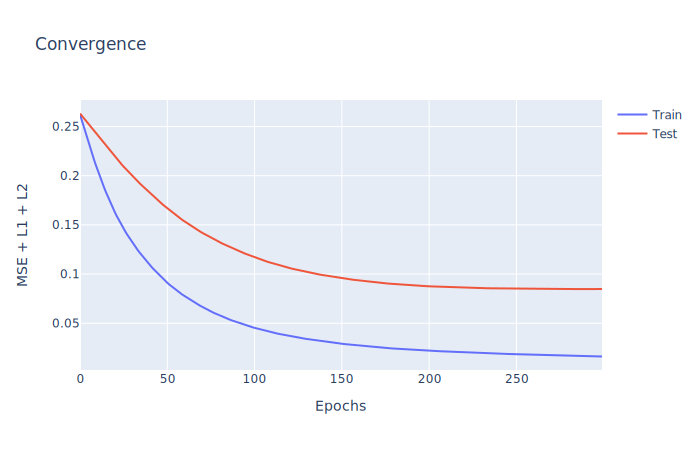

In [10]:
plot.convergence(
    losses=[train_loss_history, test_loss_history],
    names=['Train', 'Test'],
    xaxis_title='Epochs',
    yaxis_title='MSE + L1 + L2'
)

In [11]:
torch.save(model, OUTPUT_PATH)

## Tests

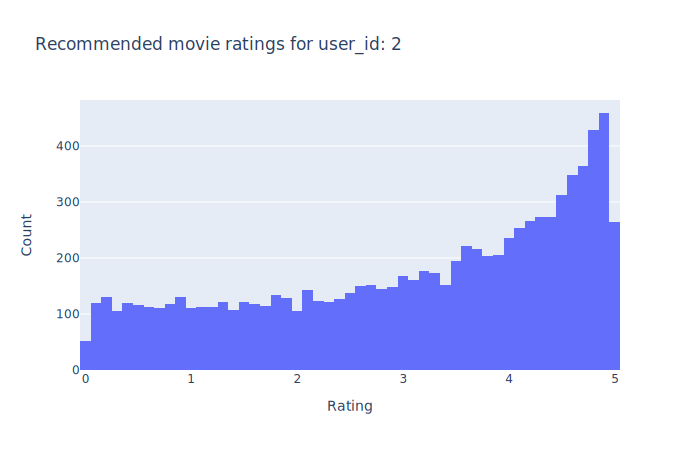

In [12]:
with torch.no_grad():
    _, scores = model.predict_scores(2)
    plot.histogram(
        x=scores,
        title=f'Recommended movie ratings for user_id: {2}',
        xaxis_title='Rating',
        yaxis_title='Count'
    )

Testing predictions: 100%|██████████| 656/656 [00:04<00:00, 133.99it/s]


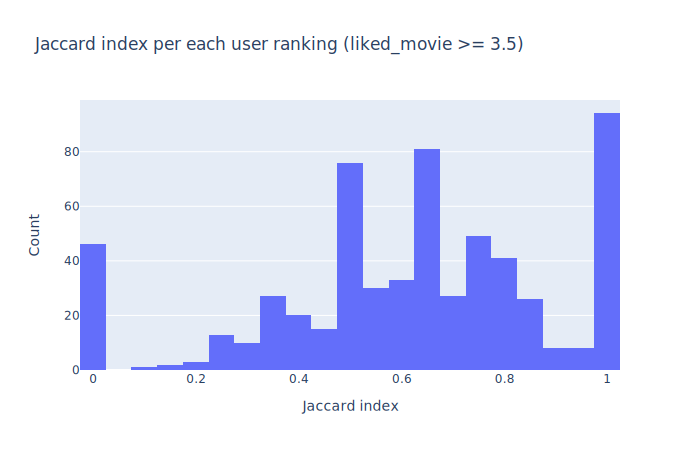

In [13]:
with torch.no_grad():
    jaccard_ranking = get_jaccard_ranking(model, test_ratings)
    plot.histogram(
        x=jaccard_ranking,
        title='Jaccard index per each user ranking (liked_movie >= 3.5)',
        xaxis_title='Jaccard index',
        yaxis_title='Count'
    )

Testing predictions: 100%|██████████| 656/656 [00:04<00:00, 133.74it/s]


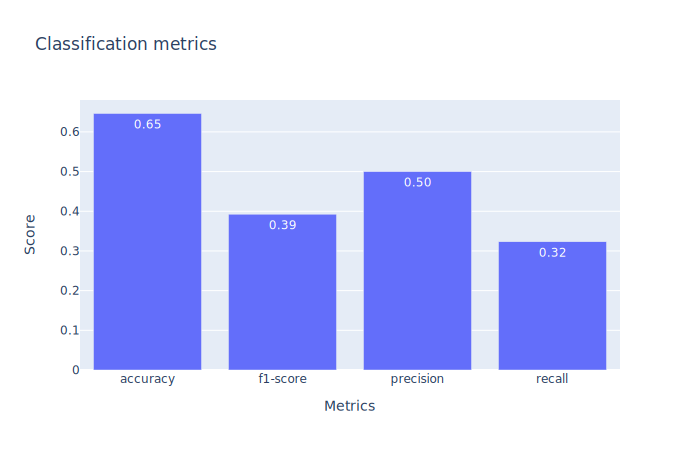

In [14]:
with torch.no_grad():
    classification_metrics = get_classification_ranking_metrics(model, test_ratings)
    plot.bar(
        classification_metrics,
        title='Classification metrics',
        xaxis_title='Metrics',
        yaxis_title='Score'
    )

In [15]:
with torch.no_grad():
    r2_score = get_r2_score(model, test_ratings)
    print(f'\n\nr2 score: {r2_score:.3f}')

Testing predictions: 100%|██████████| 656/656 [00:05<00:00, 126.11it/s]

r2 score: -0.651

